## FrozenLake-V0
#### $\epsilon$-greedy $Q$-Learning approach to solve FrozenLake-v0 enivronment from OpenAI-Gym  

***FrozenLake-v0 environment***

The agent controls the movement of a character in a grid world. Some tiles of the grid are walkable, and others lead to the agent falling into the water. Additionally, the movement direction of the agent is uncertain and only partially depends on the chosen direction. The agent is rewarded for finding a walkable path to a goal tile.

Winter is here. You and your friends were tossing around a frisbee at the park when you made a wild throw that left the frisbee out in the middle of the lake. The water is mostly frozen, but there are a few holes where the ice has melted. If you step into one of those holes, you'll fall into the freezing water. At this time, there's an international frisbee shortage, so it's absolutely imperative that you navigate across the lake and retrieve the disc. However, the ice is slippery, so you won't always move in the direction you intend.

The surface is described using a grid like the following:
```
SFFF       (S: starting point, safe)
FHFH       (F: frozen surface, safe)
FFFH       (H: hole, fall to your doom)
HFFG       (G: goal, where the frisbee is located)

```
The episode ends when you reach the goal or fall in a hole. You receive a reward of 1 if you reach the goal, and zero otherwise.  


In [1]:
import gym
from gym import wrappers
from matplotlib import pyplot as plt
import json
from os import listdir

%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


http://www.cs.cmu.edu/afs/cs/project/jair/pub/volume4/kaelbling96a.pdf

***$Q$-Learning :***

```
                                      - - - < -  Action  - - < - - -
                                     |                              | 
                                     |                              | 
                                _____________                    _______
                               | Environment |                  | Agent |
                               |_____________|                  |_______|
                                     |                              |
                                     |                              |
                                      - - - > -  State  - - > - - -  

```
Consider an environment which has a vehicle that wants to reach a known location. An agent helps the vehicle in reaching its desitnation by providing instructions. After following the instruction the vehicle sends back its current state in the environment to the agent, so that the agent can make next decision.
Lets call an instruction as an action and vehicles current state in the environment as a state. An action could be as simple as move up, down, right or left. A state can be combination of gps coordinates, sensory information from the vehicle like pixel data from camera, lidar information etc.

In order to provide actions to the vehicle the agent should either be intelligent or should fake it until it becomes intelligent, that is, may be to start with it can provide random actions, learn based on the feedback from the environment and finally refine its learning.
There are many ways for an agent to learn, Reinforcement Learning is one of them. The figure below depicts what happens in Reinforcement learning. Everything that has been explained above stays the same about environment and agent, but there is an additional input that an agent receives from the environment, that is, Reward.  

```
                                  - - - < -  Action  - - < - - -
                                 |                              | 
                                 |                              | 
                            _____________                    _______
                           | Environment |                  | Agent |
                           |_____________|                  |_______|
                                 |  |                          |  |
                                 |  |                          |  |
                                 |   - - > - - Reward - - > - -   |
                                 |                                |                                 
                                  - - > - - - State  - - > - - - - 

```
A reward can be considered as a feedback, but more of a way to motivate the agent to learn to do the right thing. For example agent would receive a positive reward if the action instructed by the agent has moved the vehicle to next state safely without causing an accident and a negative reward if it has caused an accident.

```
                      - - - < -  Action  - - < - - -
                     |                              | 
                     |                              | 
                _____________                    _______                  _______ 
               | Environment |                  | Agent |- < - - - - > - |Q-Table|
               |_____________|                  |_______|                |_______|
                     |  |                          |  |
                     |  |                          |  |
                     |   - - > - - Reward - - > - -   |
                     |                                |                                 
                      - - > - - - State  - - > - - - - 

                                          Q-Learning 
```

$Q$-Learning is a basic Reinforcement learning techinique. It is simple and easy to implement, especially if our states are discrete and the state space is small. To start with the agent provides random actions as input to the environment and bulids a table which eventually helps it in making the right decisions. The table is called as a Q table. The table would look similar to the one below.

|States|Action,Q-value pairs
|------|--------|---------
|State-1| {'Action-1': -20, 'Action-2': 10}
|State-2| {'Action-1': 20, 'Action-2': 0}

The table has two columns, namely, states and action,Q-value pairs. Each row in the table has information about a unique state and its corresponding action Q-value pairs, for all possible actions when the vehicle is in that state. The Q values are values that are learned by the agent from the feedback provided by the environment. 

Assume that the agent has a Q Table as above and it wants to send an input to vehicle which is at 'state-1'. The agent first looks at all the action Q value pairs for that state, then chooses the action with highest Q value and sends it to the vehicle. The vehicle then sends back a reward and next state so that the agent can update the Q value for the action. The equation for updating the Q value is given by

$$ Q(s,a) = R(s,a) + \gamma(\max_{a'}Q(s',a')) $$

We want to learn the Q value over time, the Q value learning rule or the $Q$-Learning rule is give by :

$$ Q(s,a) := Q(s,a) + \alpha(R(s,a) + \gamma(\max_{a'}Q(s',a')) - Q(s,a)) $$

Where   
  $Q$ is $Q$ function  
  $R$ is reward function   
  $\alpha$ is Learning rate      
  $\gamma$ is Discount factor  
  $s$ is current state  
  $s'$ is future state  
  $a$ is current action  
  $a'$ is future action  
  


In [2]:
import random
import math

RESULTS_PATH = 'tmp/results'

class Agent(object):
    """ An agent that learns to balance the CartPole """ 

    def __init__(self,env, learning, epsilon=1.0, gamma=0.5, alpha=0.5, valid_actions=[]):

        # Paramters for the agent 
        self.env = env 
        self.valid_actions = valid_actions
        self.learning = learning # Whether the agent is expected to learn
        self.Q = dict()          # Create a Q-table which will be a dictionary of tuples
        self.epsilon = epsilon   # Random exploration factor
        self.alpha = alpha       # Learning factor
        self.gamma = gamma       # Discount factor
        self.current_state = env.reset() # Current state of the agent
        self.done = False        # Whether it is time to reset the environment

        self.epsilon_0 = epsilon # initial value of epsilon
        self.alpha_0 = alpha     # initial value of alpha
        self.total_trail = 1

    def reset(self,testing=False):
        """ The reset function is called at the beginning of each trial.
            'testing' is set to True if testing trials are being used
            once training trials have completed. """

        self.current_state = self.env.reset()

        # Decay function for epsilon
        constant = 0.0001

        self.epsilon =  self.epsilon_0 * math.exp(-constant*self.total_trail)
        #self.epsilon -= 0.0001
        

        # Decay function for alpha (not usual to implement this)
        #self.alpha = self.alpha_0 * math.exp(-constant*self.total_trail)
        self.alpha = max(self.alpha-0.001, 0.05 )

        self.total_trail += 1

        # change params for testing 

    def build_state(self):
        """ The build_state function is called when the agent requests data from the 
            environment. """

        return self.current_state


    def get_maxQ(self, state):
        """ The get_max_Q function is called when the agent is asked to find the
            maximum Q-value of all actions based on the 'state' the agent is in. """

        maxQ = max(self.Q[state].values())

        return maxQ

    def createQ(self, state):
        """ The createQ function is called when a state is generated by the agent. """
        if state in self.Q:
            pass
        else :
            self.Q[state] = dict(zip(self.valid_actions, [0] * len(self.valid_actions)))

    def choose_action(self, state):
        """ The choose_action function is called when the agent is asked to choose
            which action to take, based on the 'state' the agent is in. """


        if not self.learning:
            action = self.env.action_space.sample()
            return action

        if random.random() < self.epsilon:
            action = self.env.action_space.sample()

        else :
            maxQ = self.get_maxQ(state)
            action = random.choice([key for key in self.Q[state] if self.Q[state][key]==maxQ])
            
        return action


    def learn(self, state, action, reward):
        """ The learn function is called after the agent completes an action and
            receives an award. This function does not consider future rewards 
            when conducting learning. """

        # Qnew = (1-alpha)*Qold + alpha*(gamma*max(Qnext))
        try :
            # If Q table already has current_state 
            self.Q[state][action] = self.alpha*(reward - self.Q[state][action] + \
                    (self.gamma*self.get_maxQ(self.current_state))) + self.Q[state][action]
        except :
            self.Q[state][action] = (self.alpha*reward) + ((1 - self.alpha)*self.Q[state][action])
        


    def update(self):
        """ The update function is called when a time step is completed in the 
            environment for a given trial. This function will build the agent
            state, choose an action, receive a reward, and learn if enabled. """

        state = self.build_state()          # Get current state
        self.createQ(state)                 # Create 'state' in Q-table
        action = self.choose_action(state)  # Choose an action

        self.current_state, reward, self.done, info = self.env.step(action)
        
        self.learn(state, action, reward)   # Q-learn

        return


In [3]:
def run():
    # Initializing the environment 
    env = gym.make('FrozenLake-v0')
    # Identifying the valid actions
    valid_actions = range(env.action_space.n)
    # Initializing the mornitoring of the environment, this saves the results and stats
    env = wrappers.Monitor(env, RESULTS_PATH,force=True)
    # Initializing the agent 
    agent = Agent(env=env,epsilon=0.05,alpha=0.99,gamma=0.99,learning=True,valid_actions=valid_actions)
    # Learning process starts here
    while agent.epsilon > 0.03:
        agent.update()
        if agent.done :
            agent.reset()

    env.close()
    #gym.upload(RESULTS_PATH,api_key=<api-key>)
    #print agent.Q

    
run()

[2017-03-08 19:55:43,060] Making new env: FrozenLake-v0
[2017-03-08 19:55:43,157] Clearing 30 monitor files from previous run (because force=True was provided)
[2017-03-08 19:55:43,161] Starting new video recorder writing to /Users/mmuppidi/Documents/Personal/Projects/ML/reinforcement_learning/tmp/results/openaigym.video.0.19089.video000000.json
[2017-03-08 19:55:43,164] Starting new video recorder writing to /Users/mmuppidi/Documents/Personal/Projects/ML/reinforcement_learning/tmp/results/openaigym.video.0.19089.video000001.json
[2017-03-08 19:55:43,169] Starting new video recorder writing to /Users/mmuppidi/Documents/Personal/Projects/ML/reinforcement_learning/tmp/results/openaigym.video.0.19089.video000008.json
[2017-03-08 19:55:43,176] Starting new video recorder writing to /Users/mmuppidi/Documents/Personal/Projects/ML/reinforcement_learning/tmp/results/openaigym.video.0.19089.video000027.json
[2017-03-08 19:55:43,185] Starting new video recorder writing to /Users/mmuppidi/Documen

In [4]:
def get_episode_batch_file_name(results_path):
    for file_name in listdir(results_path):
        if 'openaigym.episode_batch' in file_name:
            return results_path+ '/'+ file_name
        
def element_wise_average(rewards):
    reward_avg = [sum(rewards[:i])/(i+1) for i in range(len(rewards))]
    return reward_avg

def get_consecutive_100_episode_average_list(rewards):
    consecutive_average = [sum(rewards[:100])/100.0]
    for i in range(100,len(rewards)):
        consecutive_average.append(sum(rewards[i-100 : i])/100.0)
    return consecutive_average

# Loading the results
result = json.load(open(get_episode_batch_file_name(RESULTS_PATH)))

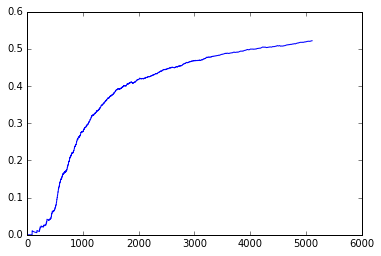

In [5]:
# Average of rewards till that episode vs episodes
plt.plot(element_wise_average(result['episode_rewards']))
plt.show()

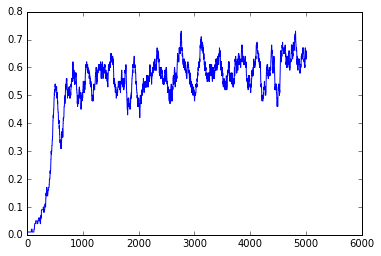

In [6]:
# Average of 100 rewards till that episode vs episodes
plt.plot(get_consecutive_100_episode_average_list(result['episode_rewards']))
plt.show()

In [7]:
print "Best 100-episode average reward was {}".format( \
                max(get_consecutive_100_episode_average_list(result['episode_rewards'])))

print "The average reward was {}".format(sum(result['episode_rewards'])/len(result['episode_rewards']))

Best 100-episode average reward was 0.73
The average reward was 0.521824231748


***References :***   
[1] https://gym.openai.com/envs/FrozenLake-v0  
[2] https://www.udacity.com/course/machine-learning-engineer-nanodegree--nd009  
[3] https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0#.iljgpzh7m  
[4] http://karpathy.github.io/2016/05/31/rl/